**Beyond Swabs**
A Mortality-anchored Method To Estimate True Covid-19 Infections

Deaths are harder to miss than infections. Can we use confirmed deaths to determine how many cases we missed during the pandemic?
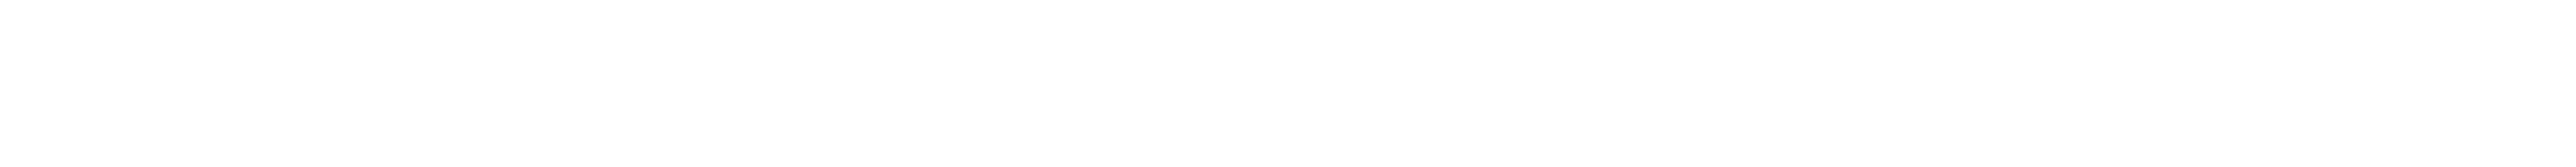

**SECTION 1** - Let's do some data wrangling

In [2]:
# libraries
import pandas as pd
import numpy as np

In [3]:
# file paths for the jhu files that contain cumulative counts for cases and deaths
f_cases  = "data_raw/time_series_covid19_confirmed_global.csv"
f_deaths = "data_raw/time_series_covid19_deaths_global.csv"

# the countries I chose for the poster
countries = ["united kingdom", "italy", "france", "saudi arabia"]

In [4]:
# read the data, it is a wide table and I will turn it in the next step to a long table
cases_raw  = pd.read_csv(f_cases)
deaths_raw = pd.read_csv(f_deaths)

In [5]:
"""
turn the wide jhu table into a tidy daily table:
- melt wide date columns to rows
- parse date
- sum provinces to country-day
- compute daily counts by differencing the cumulative
"""

def tidy_jhu(df):

    id_cols = ["Province/State", "Country/Region", "Lat", "Long"]
    long = df.melt(id_vars=id_cols, var_name="date", value_name="cum")
    long["date"] = pd.to_datetime(long["date"], format="%m/%d/%y")

    # sum provinces to country level by day
    long = (
        long.groupby(["Country/Region", "date"], as_index=False)["cum"]
            .sum()
            .rename(columns={"Country/Region": "country"})
            .sort_values(["country", "date"])
    )

    # compute daily incident counts from cumulative
    long["daily"] = (
        long.groupby("country")["cum"].diff().fillna(0).clip(lower=0)
        # clip prevents negative dips from data revisions
    )

    long["country"] = long["country"].str.lower()

    return long


In [6]:
# running the tidy_jhu function
cases_long  = tidy_jhu(cases_raw)
deaths_long = tidy_jhu(deaths_raw).rename(columns={"daily": "daily_deaths",
                                                   "cum": "cum_deaths"})

In [7]:
# just checking the dates are correct
print(cases_long["date"].min(), cases_long["date"].max())
print(deaths_long["date"].min(), deaths_long["date"].max())

2020-01-22 00:00:00 2023-03-09 00:00:00
2020-01-22 00:00:00 2023-03-09 00:00:00


In [8]:
# keeping only the countries we previously selected
cases_long  = cases_long[cases_long["country"].isin(countries)].copy()
deaths_long = deaths_long[deaths_long["country"].isin(countries)].copy()

In [9]:
# turn our daily data to weekly data, so the plots look much better later
wk_cases = (
    cases_long.loc[:, ["country", "date", "daily"]]
    .set_index("date")
    .groupby("country")
    .resample("W-SUN")["daily"]
    .sum()
    .reset_index()
    .rename(columns={"date": "week", "daily": "cases_w"})
)

wk_deaths = (
    deaths_long.loc[:, ["country", "date", "daily_deaths"]]
    .set_index("date")
    .groupby("country")
    .resample("W-SUN")["daily_deaths"]
    .sum()
    .reset_index()
    .rename(columns={"date": "week", "daily_deaths": "deaths_w"})
)

In [10]:
# checking everything is fine before the merge
print("wk_cases cols:", wk_cases.columns.tolist())
print("wk_deaths cols:", wk_deaths.columns.tolist())

wk_cases cols: ['country', 'week', 'cases_w']
wk_deaths cols: ['country', 'week', 'deaths_w']


In [11]:
# now we merge
wk = (
    wk_cases.merge(wk_deaths, on=["country", "week"], how="outer")
            .sort_values(["country", "week"])
)

# filling missing values with zero
wk[["cases_w", "deaths_w"]] = wk[["cases_w", "deaths_w"]].fillna(0)

In the poster, I stated that I will be using a delay of 14 days (~2 weeks) to calculate the dCFR.
The code for the plots I used to estimate the delay period (by eye) was done in R, and it can be found at R/detecting_the_delay.R


In [12]:
# 14-day delay ≈ shift deaths backward 2 weeks
wk["deaths_w_back2w"] = wk.groupby("country")["deaths_w"].shift(-2)

In [13]:
# dCFR for week t now means: deaths at t+2 divided by cases at t
wk["dcfr"] = np.where(wk["cases_w"] > 0, wk["deaths_w_back2w"] / wk["cases_w"], np.nan)

In [14]:
# we can't backshift the last 2 weeks, so might as well drop them
wk = wk[wk["deaths_w_back2w"].notna()].copy()

In [15]:
# save the long table with dCFR
wk.to_csv("data_output/jhu_weekly_tidy.csv", index=False)

**SECTION 2** — weekly age-standardized IFR and true infections

In [16]:
# inputs:
#   data_output/jhu_weekly_tidy.csv         (from section 1)
#   data_raw/ifr_age_date.xlsx              (Ward et al. age-specific IFR over time)
#   data_raw/age_distribution.csv           (selected countries age_groups)
# output:
#   data_output/est_infections_weekly.csv   (everything in one table)

In [17]:
# load the IFR values
ifr_raw = pd.read_excel("data_raw/ifr_age_date.xlsx")

# make all countries in lowercase
ifr_raw.columns = [c.strip().lower() for c in ifr_raw.columns]

# renaming columns because I don't like them the way they are
ifr_raw.rename(columns={'mid_date': 'date',
                        'category': 'age_group',
                        'rate_lower': 'ifr_low',
                        'rate_upper': 'ifr_high',
                        'rate_median': 'ifr_med'},
               inplace=True)

ifr_raw

,date,age_group,ifr_low,ifr_high,ifr_med
0,2020-11-08,25-44,0.000216,0.000425,0.000302
1,2021-01-03,25-44,0.000269,0.000511,0.000373
2,2021-01-31,25-44,0.000286,0.000548,0.000401
3,2021-03-14,25-44,0.000279,0.000549,0.000391
4,2021-04-11,25-44,0.000252,0.000513,0.000356
...,...,...,...,...,...
224,2022-12-18,75+,0.004412,0.008860,0.006313
225,2023-01-01,75+,0.005159,0.009447,0.007020
226,2023-01-15,75+,0.005749,0.011148,0.008017
227,2023-01-29,75+,0.005505,0.010675,0.007746


In [18]:
ifr = ifr_raw.loc[:, ["date", "age_group", "ifr_low", "ifr_med", "ifr_high"]].copy()
ifr["date"] = pd.to_datetime(ifr["date"])
ifr["age_group"] = ifr["age_group"].astype(str).str.strip()

In [19]:
# forward-fill each of low/med/high onto the weekly index we actually use
week_index = np.sort(wk["week"].unique())

def make_weekly_long(source_df, value_col):
    pvt = (source_df
           .pivot(index="date", columns="age_group", values=value_col)
           .sort_index())
    pvt_w = pvt.reindex(week_index, method="ffill")
    out = (pvt_w
           .stack()
           .rename_axis(["week", "age_group"])
           .reset_index(name=value_col)
    )

    out["week"] = pd.to_datetime(out["week"])
    out["age_group"] = out["age_group"].astype("string").str.strip()

    return out

In [20]:
ifr_med_week  = make_weekly_long(ifr, "ifr_med")
ifr_low_week  = make_weekly_long(ifr, "ifr_low")
ifr_high_week = make_weekly_long(ifr, "ifr_high")

In [21]:
# load age distribution per country
age_raw = pd.read_csv("data_raw/age_distribution.csv")

age_raw.rename(columns={'Region, subregion, country or area *': 'country'}, inplace=True)
age_raw["country"] = age_raw["country"].str.lower()

Now, I have 2 files with different age groups that I need to do some calculations on. In order to do that, they both must have the same age groups.

In [22]:
print(ifr['age_group'].unique())

print(len(ifr['age_group'].unique()))
# 6 age groups in ifr table

['25-44' '45-54' '55-64' '6-24' '65-74' '75+']
6


In [23]:
print(age_raw.columns[-21:])

print(len(age_raw.columns[-21:]))
# 21 age groups in age_raw

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80-84', '85-89', '90-94', '95-99', '100+'],
      dtype='object')
21


In [24]:
# match the age_raw age groups with the six IFR age groups
#    6–24  = (5–9) + (10–14) + (15–19) + (20–24)
#    25–44 = (25–29) + (30–34) + (35–39) + (40–44)
#    45–54 = (45–49) + (50–54)
#    55–64 = (55–59) + (60–64)
#    65–74 = (65–69) + (70–74)
#    75+   = (75–79) + (80–84) + (85–89) + (90–94) + (95–99) + (100+)

age_raw["grp_6_24"]  = age_raw["5-9"] + age_raw["10-14"] + age_raw["15-19"] + age_raw["20-24"]
age_raw["grp_25_44"] = age_raw["25-29"] + age_raw["30-34"] + age_raw["35-39"] + age_raw["40-44"]
age_raw["grp_45_54"] = age_raw["45-49"] + age_raw["50-54"]
age_raw["grp_55_64"] = age_raw["55-59"] + age_raw["60-64"]
age_raw["grp_65_74"] = age_raw["65-69"] + age_raw["70-74"]
age_raw["grp_75p"]   = (age_raw["75-79"] + age_raw["80-84"] + age_raw["85-89"] +
                        age_raw["90-94"] + age_raw["95-99"] + age_raw["100+"])

In [25]:
# this is a new table that contains the new age groups per country, looks neat

shares = pd.DataFrame({
    "country": age_raw["country"],
    "6-24":  age_raw["grp_6_24"],
    "25-44": age_raw["grp_25_44"],
    "45-54": age_raw["grp_45_54"],
    "55-64": age_raw["grp_55_64"],
    "65-74": age_raw["grp_65_74"],
    "75+":   age_raw["grp_75p"],
})

shares

,country,6-24,25-44,45-54,55-64,65-74,75+
0,saudi arabia,9680.2630,13075.3285,3154.4705,1541.5095,521.3500,260.4285
1,united kingdom,16188.2745,17631.1310,8989.1310,8189.7965,6763.8440,5767.5055
2,italy,11296.9985,14162.0150,9605.4935,8595.2300,6884.1830,7122.9630
3,france,15884.8370,15763.8105,8677.6300,8381.1470,7390.5495,6283.1090


In [26]:
# normalize the six age-bin counts into shares (proportions) that sum to 1 for each country (since we ignored the 0-4 age group because of lack of IFR data)
tot = shares[["6-24","25-44","45-54","55-64","65-74","75+"]].sum(axis=1)
shares[["6-24","25-44","45-54","55-64","65-74","75+"]] = shares[["6-24","25-44","45-54","55-64","65-74","75+"]].div(tot, axis=0)

In [27]:
# tidy long form for merging with ifr later ['country', 'age_group', 'share']

age = shares.melt(id_vars="country", var_name="age_group", value_name="share")
age["age_group"] = age["age_group"].astype(str).str.strip()

age

,country,age_group,share
0,saudi arabia,6-24,0.342866
1,united kingdom,6-24,0.254814
2,italy,6-24,0.195901
3,france,6-24,0.254642
4,saudi arabia,25-44,0.463116
5,united kingdom,25-44,0.277526
6,italy,25-44,0.245583
7,france,25-44,0.252702
8,saudi arabia,45-54,0.111729
9,united kingdom,45-54,0.141495


In [28]:
# save the table
age.to_csv("data_output/age_shares_ifr_bins.csv", index=False)

Now, the big merge

In [29]:
# build (country, week, age_group) grid and attach shares + weekly ifr (low/med/high)

week_index = np.sort(wk["week"].unique())

countries = np.sort(wk["country"].str.lower().unique())
weeks = week_index

In [30]:
grid = pd.MultiIndex.from_product([countries, weeks], names=["country", "week"]).to_frame(index=False)
grid = grid.merge(age, on="country", how="left")
grid = grid.merge(ifr_med_week, on=["week","age_group"], how="left")
grid = grid.merge(ifr_low_week, on=["week","age_group"], how="left", suffixes=("", "_drop1"))
grid = grid.merge(ifr_high_week, on=["week","age_group"], how="left", suffixes=("", "_drop2"))

# jhu data start much earlier than IFR data, so I'm just going to drop the early weeks
grid = grid[grid["ifr_med"].notna()].copy()

grid["w_ifr_med"]  = grid["share"] * grid["ifr_med"]
grid["w_ifr_low"]  = grid["share"] * grid["ifr_low"]
grid["w_ifr_high"] = grid["share"] * grid["ifr_high"]

grid['country'].unique()

array(['france', 'italy', 'saudi arabia', 'united kingdom'], dtype=object)

In [31]:
# weekly IFR for every country

ifr_country_week = (
    grid.groupby(["country","week"], as_index=False)[["w_ifr_low","w_ifr_med","w_ifr_high"]]
        .sum()
        .rename(columns={
            "w_ifr_low":  "ifr_low_w",
            "w_ifr_med":  "ifr_med_w",
            "w_ifr_high": "ifr_high_w"
        })
)

In [32]:
out = (
    wk.assign(country=wk["country"].str.lower())
      .merge(ifr_country_week, on=["country","week"], how="inner")  # <- inner, not left
      .dropna(subset=["deaths_w_back2w"])  # drop last 2 weeks with no back-shifted deaths
)

In [33]:
# detection fraction
out["det_frac_low"]  = (out["ifr_low_w"] / out["dcfr"]).clip(0, 1)
out["det_frac_med"]  = (out["ifr_med_w"] / out["dcfr"]).clip(0, 1)
out["det_frac_high"] = (out["ifr_high_w"] / out["dcfr"]).clip(0, 1)

# infections — death-based (uses deaths shifted back 2w)
out["inf_death_low"] = out["deaths_w_back2w"] / out["ifr_low_w"]
out["inf_death_med"] = out["deaths_w_back2w"] / out["ifr_med_w"]
out["inf_death_high"] = out["deaths_w_back2w"] / out["ifr_high_w"]

# infections — case-based
out["inf_case_low"] = out["cases_w"] * (out["dcfr"] / out["ifr_low_w"])
out["inf_case_med"] = out["cases_w"] * (out["dcfr"] / out["ifr_med_w"])
out["inf_case_high"] = out["cases_w"] * (out["dcfr"] / out["ifr_high_w"])

In [34]:
# QUICK SANITY CHECK - I AM LOSING MY MIND
print(out.isna().sum())
print(out.groupby("country")[["week"]].count().head()) # weeks kept per country

country            0
week               0
cases_w            0
deaths_w           0
deaths_w_back2w    0
dcfr               0
ifr_low_w          0
ifr_med_w          0
ifr_high_w         0
det_frac_low       0
det_frac_med       0
det_frac_high      0
inf_death_low      0
inf_death_med      0
inf_death_high     0
inf_case_low       0
inf_case_med       0
inf_case_high      0
dtype: int64
                week
country             
france           135
italy            135
saudi arabia     135
united kingdom   135


In [206]:
out.to_csv("data_output/est_infections_weekly.csv", index=False)

Perfect. Now we move to RStudio for plotting.
Sorry. I don't know how to plot with python.